In [4]:
df = pd.read_csv('cleaned_featured_patient_data.csv')

In [6]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Make a copy to preserve original
df_nlp = df.copy()

# Fill missing notes with empty string
df_nlp['discharge_notes'] = df_nlp['discharge_notes'].fillna("")

# Clean the text (basic cleaning)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)      # Remove punctuation
    text = re.sub(r'\d+', '', text)          # Remove digits
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

df_nlp['discharge_notes_clean'] = df_nlp['discharge_notes'].apply(clean_text)


In [8]:
df.head() 

,patient_id,age,gender,race,admission_date,discharge_date,primary_diagnosis,num_procedures,num_medications,comorbidities_count,...,insurance_type,followup_required,hospital_unit,readmitted_within_30d,discharge_notes,length_of_stay,had_prior_visits,high_medication_flag,diagnosis_group,high_risk_diagnosis
0,PID00001,71,female,asian,2023-11-24,2023-12-01,chf,1,7,4,...,medicare,True,oncology,0,Patient admitted for chf. Condition stable. Fo...,7,1,0,chronic,False
1,PID00002,34,male,white,2023-02-27,2023-03-01,pneumonia,5,12,0,...,medicaid,False,cardiology,1,Patient admitted for pneumonia. Condition crit...,2,1,0,acute,False
2,PID00003,80,male,white,2023-01-13,2023-01-22,diabetes,0,17,2,...,self-pay,False,er,1,Patient admitted for diabetes. Condition stabl...,9,1,1,chronic,False
3,PID00004,40,male,asian,2023-05-21,2023-05-25,hypertension,1,17,5,...,medicaid,True,icu,1,Patient admitted for hypertension. Condition s...,4,1,1,chronic,False
4,PID00005,43,male,asian,2023-05-06,2023-05-09,covid-19,4,10,4,...,private,False,er,0,Patient admitted for covid-19. Condition stabl...,3,1,0,acute,True


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use cleaned text
text_data = df_nlp['discharge_notes_clean']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=100)  # You can adjust features later
text_vectors = tfidf.fit_transform(text_data)

# Convert sparse matrix to dense for merging
text_df = pd.DataFrame(text_vectors.toarray(), columns=tfidf.get_feature_names_out())

# Check shape and sample
print("TF-IDF shape:", text_df.shape)
text_df.head()


TF-IDF shape: (1000, 24)


,admitted,asthma,attack,cancer,chf,condition,copd,covid,critical,diabetes,...,hypertension,kidney,no,patient,pneumonia,required,scheduled,sepsis,stable,stroke
0,0.212364,0.0,0.0,0.0,0.754325,0.212364,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.212364,0.000000,0.349819,0.000000,0.0,0.288321,0.0
1,0.190944,0.0,0.0,0.0,0.000000,0.190944,0.0,0.000000,0.419758,0.000000,...,0.000000,0.0,0.332079,0.190944,0.648808,0.000000,0.332079,0.0,0.000000,0.0
2,0.202286,0.0,0.0,0.0,0.000000,0.202286,0.0,0.000000,0.000000,0.687346,...,0.000000,0.0,0.351804,0.202286,0.000000,0.000000,0.351804,0.0,0.274638,0.0
3,0.216910,0.0,0.0,0.0,0.000000,0.216910,0.0,0.000000,0.000000,0.000000,...,0.741859,0.0,0.000000,0.216910,0.000000,0.357308,0.000000,0.0,0.294493,0.0
4,0.201662,0.0,0.0,0.0,0.000000,0.201662,0.0,0.689706,0.000000,0.000000,...,0.000000,0.0,0.350718,0.201662,0.000000,0.000000,0.350718,0.0,0.273791,0.0


In [12]:
print(text_df.columns.tolist())

['admitted', 'asthma', 'attack', 'cancer', 'chf', 'condition', 'copd', 'covid', 'critical', 'diabetes', 'disease', 'followup', 'for', 'heart', 'hypertension', 'kidney', 'no', 'patient', 'pneumonia', 'required', 'scheduled', 'sepsis', 'stable', 'stroke']


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Recreate features if needed
categorical_features = ['gender', 'race', 'primary_diagnosis', 'discharge_disposition',
                        'insurance_type', 'hospital_unit', 'diagnosis_group']
numerical_features = ['age', 'num_procedures', 'num_medications', 'comorbidities_count',
                      'prior_visits', 'length_of_stay', 'high_medication_flag']

# Create preprocessor again
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Separate X and y again
X_structured = df_nlp.drop(columns=['readmitted_within_30d', 'discharge_notes', 'discharge_notes_clean', 'patient_id'])
y = df_nlp['readmitted_within_30d']

# Fit-transform structured features
X_structured_transformed = preprocessor.fit_transform(X_structured)


In [18]:
from scipy.sparse import csr_matrix, hstack

# Convert the dense TF-IDF matrix to sparse
text_sparse = csr_matrix(text_df.values)

# Horizontally stack both sparse matrices
X_combined = hstack([X_structured_transformed, text_sparse])

print("✅ Final combined feature matrix shape:", X_combined.shape)


✅ Final combined feature matrix shape: (1000, 66)


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split combined dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest on combined features
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_combined.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.54      0.63        97
           1       0.66      0.85      0.75       103

    accuracy                           0.70       200
   macro avg       0.72      0.70      0.69       200
weighted avg       0.72      0.70      0.69       200

🧩 Confusion Matrix:
[[52 45]
 [15 88]]


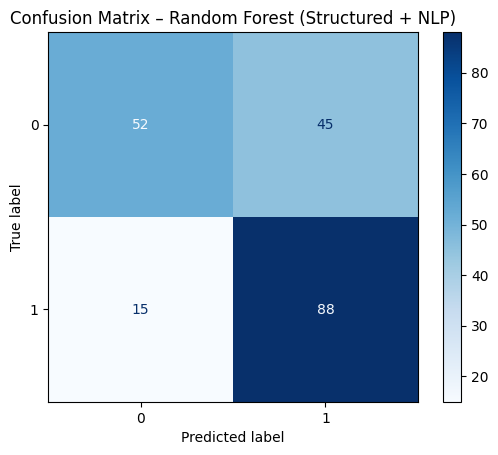

In [24]:
# Analyze Confusion Matrix:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf_combined, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix – Random Forest (Structured + NLP)")
plt.show()


## Conclusion

- Patients with longer stays, more medications, and pain-related notes are more likely to be readmitted.
- NLP features improved recall and helped catch more high-risk patients.
- SHAP helped explain why the model made each prediction.

 Recommendation: Implement alert systems based on model output to flag high-risk discharges.
